In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt

In [2]:
cpu_temp = pd.read_csv("../data/cpu-temp.csv", header=None, names=["time", "cpu_temp"])
fan_speed = pd.read_csv("../data/fan-speed.csv", header=None, names=["time", "fan_speed"])
inlet_temp = pd.read_csv("../data/inlet-temp.csv", header=None, names=["time", "inlet_temp"])
it_power = pd.read_csv("../data/it-power.csv", header=None, names=["time", "it_power"])

In [3]:
def process_dataframe(df, time_col, value_col):
    df[time_col] = df[time_col].astype(int)

    min_time = df[time_col].min()
    max_time = df[time_col].max()
    full_index = pd.DataFrame({time_col: np.arange(min_time, max_time + 1)})

    df_full = pd.merge(full_index, df, on=time_col, how='left')
    df_full[value_col] = df_full[value_col].interpolate(method="polynomial", order=2)

    return df_full

cpu_temp_new = process_dataframe(cpu_temp, "time", "cpu_temp")
fan_speed_new = process_dataframe(fan_speed, "time", "fan_speed")
inlet_temp_new = process_dataframe(inlet_temp, "time", "inlet_temp")
it_power_new = process_dataframe(it_power, "time", "it_power")

In [4]:
max_start = max(inlet_temp_new['time'].min(), cpu_temp_new['time'].min(), it_power_new['time'].min(), fan_speed_new['time'].min())
min_end = min(inlet_temp_new['time'].max(), cpu_temp_new['time'].max(), it_power_new['time'].max(), fan_speed_new['time'].max())

cpu_temp_filtered = cpu_temp_new[(cpu_temp_new['time'] >= max_start) & (cpu_temp_new['time'] <= min_end)]
inlet_temp_filtered = inlet_temp_new[(inlet_temp_new['time'] >= max_start) & (inlet_temp_new['time'] <= min_end)]
it_power_filtered = it_power_new[(it_power_new['time'] >= max_start) & (it_power_new['time'] <= min_end)]
fan_speed_filtered = fan_speed_new[(fan_speed_new['time'] >= max_start) & (fan_speed_new['time'] <= min_end)]

combined_df = pd.merge(cpu_temp_filtered, inlet_temp_filtered, on='time')
combined_df = pd.merge(combined_df, it_power_filtered, on='time')
combined_df = pd.merge(combined_df, fan_speed_filtered, on='time')

combined_df.head()

,time,cpu_temp,inlet_temp,it_power,fan_speed
0,4718,55.766525,22.468243,177.345436,3929.161963
1,4719,55.608490,22.468213,177.350546,3929.225715
2,4720,55.446706,22.468188,177.362315,3929.311931
3,4721,55.238044,22.468170,177.380743,3929.420613
4,4721,54.960208,22.468170,177.380743,3929.420613


In [5]:
df = combined_df.copy()
print(f"Shape of Final Dataframe = {df.shape}")

scalers = {
    'cpu_temp': MinMaxScaler(),
    'inlet_temp': MinMaxScaler(),
    'it_power': MinMaxScaler(),
    'fan_speed': MinMaxScaler()
}

df_scaled = pd.DataFrame(index=df.index)

for col, scaler in scalers.items():
    df_scaled[col] = scaler.fit_transform(df[[col]]).ravel()

Shape of Final Dataframe = (4255, 5)


In [6]:
def prepare_data(scaled_df, seq_length=8, k_step=24):

    # Define the input and output features
    features_cols = ['cpu_temp', 'inlet_temp', 'it_power']
    exogenous_col = 'fan_speed'
    output_col = 'cpu_temp'

    # Create sequences
    features = []
    exogenous = []
    outputs = []
    for i in range(len(scaled_df) - seq_length - k_step + 1):
        features.append(scaled_df[features_cols].iloc[i:i + seq_length].values)
        exogenous.append(scaled_df[exogenous_col].iloc[i + seq_length:i + seq_length + k_step].values)
        outputs.append(scaled_df[output_col].iloc[i + seq_length:i + seq_length + k_step].values)

    features = np.array(features)
    exogenous = np.array(exogenous).reshape(-1, k_step, 1)
    outputs = np.array(outputs).reshape(-1, k_step, 1)

    # Convert to PyTorch tensors
    features = torch.tensor(features, dtype=torch.float32)
    exogenous = torch.tensor(exogenous, dtype=torch.float32)
    outputs = torch.tensor(outputs, dtype=torch.float32)

    # Split into train and test
    split_ratio = 0.8
    split_index = int(len(features) * split_ratio)
    train_features, test_features = features[:split_index], features[split_index:]
    train_exogenous, test_exogenous = exogenous[:split_index], exogenous[split_index:]
    train_outputs, test_outputs = outputs[:split_index], outputs[split_index:]

    train_dataset = TensorDataset(train_features, train_exogenous, train_outputs)
    test_dataset = TensorDataset(test_features, test_exogenous, test_outputs)

    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

    return train_loader, test_loader, outputs, split_index

In [7]:
import torch
import torch.nn as nn

class WeightedDualInputAttentionLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, seq_len, k_steps):
        super(WeightedDualInputAttentionLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.seq_len = seq_len
        self.k_steps = k_steps

        self.feature_weights = nn.Parameter(torch.tensor([0.65, 0.36, 0.26], dtype=torch.float32))
        
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.attention = nn.Linear(hidden_size, 1)
        self.fc = nn.Linear(hidden_size, k_steps)  # k-step prediction

        # Modified MLP to handle fan speed correctly
        self.fan_speed_mlp = nn.Sequential(
            nn.Linear(1, hidden_size),  # Process each timestep separately
            nn.ReLU(),
            nn.Linear(hidden_size, 1)  # Ensure output is (batch_size, k_steps, 1)
        )

    def forward(self, x, fan_speed):
        x = x * self.feature_weights.unsqueeze(0).unsqueeze(0)  # Shape: (batch_size, seq_len, input_size)

        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)

        out, _ = self.lstm(x, (h0, c0))  # out shape: (batch_size, seq_len, hidden_size)
        
        attention_weights = torch.softmax(self.attention(out), dim=1)  # (batch_size, seq_len, 1)
        context_vector = torch.sum(attention_weights * out, dim=1)  # (batch_size, hidden_size)

        lstm_output = self.fc(context_vector)  # (batch_size, k_steps)

        # Ensure fan_speed passes correctly through MLP
        fan_speed_contribution = self.fan_speed_mlp(fan_speed).squeeze(-1)  # (batch_size, k_steps)

        return lstm_output + fan_speed_contribution  # Final shape: (batch_size, k_steps)


In [8]:
def train_model(model, train_loader, test_loader, k_step, learning_rate=0.001, num_epochs=10):
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

    history = {'train_loss': [], 'test_loss': []}

    # Function to compute loss
    def evaluate_loss(loader, model):
        model.eval()
        total_loss = 0
        with torch.no_grad():
            for batch_features, batch_fan_speed, batch_outputs in loader:
                # batch_fan_speed = batch_fan_speed[:, -1].unsqueeze(-1)  # Take last fan speed value
                
                outputs = model(batch_features, batch_fan_speed)  # Shape: (batch_size, k_steps)

                # Reshape batch_outputs to match outputs
                batch_outputs = batch_outputs[:, -k_step:]  # Keep last k_steps

                # print(outputs.shape)
                # print(batch_outputs.shape)

                loss = criterion(outputs, batch_outputs.squeeze(-1))  
                total_loss += loss.item()
        return total_loss / len(loader)

    # Initial loss before training
    train_loss = evaluate_loss(train_loader, model)
    test_loss = evaluate_loss(test_loader, model)
    history['train_loss'].append(train_loss)
    history['test_loss'].append(test_loss)
    print(f"Before Training: Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}")

    # Training loop
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        for batch_features, batch_fan_speed, batch_outputs in train_loader:
            # batch_fan_speed = batch_fan_speed[:, -1].unsqueeze(-1)  # Fix shape mismatch
            
            optimizer.zero_grad()
            outputs = model(batch_features, batch_fan_speed)  # Shape: (batch_size, k_steps)

            # Ensure batch_outputs shape is (batch_size, k_steps)
            batch_outputs = batch_outputs[:, -k_step:]

            loss = criterion(outputs, batch_outputs.squeeze(-1))
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        
        train_loss /= len(train_loader)
        history['train_loss'].append(train_loss)

        # Evaluate test loss
        test_loss = evaluate_loss(test_loader, model)
        history['test_loss'].append(test_loss)

        # Adjust learning rate
        scheduler.step()

        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}")

    return model, history


In [9]:
torch.manual_seed(42)
np.random.seed(42)

seq_length = 30  # Historical input window
k_step = 15  # Prediction horizon
input_size = 3  # Features: cpu_temp, inlet_temp, it_power
lstm_hidden_size = 128
num_layers = 2
learning_rate = 0.01
num_epochs = 50

In [10]:
train_loader, test_loader, outputs, split_index = prepare_data(df_scaled, seq_length, k_step)
model = WeightedDualInputAttentionLSTM(input_size, lstm_hidden_size, num_layers, k_step, seq_length, k_step)
trained_model, history = train_model(model, train_loader, test_loader, k_step, learning_rate, num_epochs)

Before Training: Train Loss: 1.2033, Test Loss: 0.5043
Epoch 1/50, Train Loss: 0.0586, Test Loss: 0.0042
Epoch 2/50, Train Loss: 0.0041, Test Loss: 0.0059
Epoch 3/50, Train Loss: 0.0047, Test Loss: 0.0046
Epoch 4/50, Train Loss: 0.0041, Test Loss: 0.0049
Epoch 5/50, Train Loss: 0.0042, Test Loss: 0.0045
Epoch 6/50, Train Loss: 0.0035, Test Loss: 0.0035
Epoch 7/50, Train Loss: 0.0033, Test Loss: 0.0038
Epoch 8/50, Train Loss: 0.0035, Test Loss: 0.0046
Epoch 9/50, Train Loss: 0.0033, Test Loss: 0.0038
Epoch 10/50, Train Loss: 0.0033, Test Loss: 0.0033
Epoch 11/50, Train Loss: 0.0030, Test Loss: 0.0029
Epoch 12/50, Train Loss: 0.0029, Test Loss: 0.0032
Epoch 13/50, Train Loss: 0.0029, Test Loss: 0.0044
Epoch 14/50, Train Loss: 0.0030, Test Loss: 0.0034
Epoch 15/50, Train Loss: 0.0030, Test Loss: 0.0029
Epoch 16/50, Train Loss: 0.0029, Test Loss: 0.0042
Epoch 17/50, Train Loss: 0.0029, Test Loss: 0.0038
Epoch 18/50, Train Loss: 0.0029, Test Loss: 0.0032
Epoch 19/50, Train Loss: 0.0029, Tes

In [11]:
import os

save_path = "../models/model_direct_demo.pth"

os.makedirs(os.path.dirname(save_path), exist_ok=True)
torch.save(model.state_dict(), save_path)
print(f"Model saved to: {save_path}")

Model saved to: ../models/model_direct_demo.pth


In [12]:
def forecast_with_exogenous(model, test_loader, scaler, k_step, modified_fan_speed):
    model.eval()
    
    for batch_features, batch_exogenous, batch_outputs in test_loader:
        pass  

    features = batch_features[-1].unsqueeze(0)  # Shape: [1, seq_length, input_size]
    exogenous = batch_exogenous[-1].unsqueeze(0)  # Shape: [1, k_step, 1]

    modified_exogenous = torch.tensor(modified_fan_speed, dtype=torch.float32).unsqueeze(0).unsqueeze(-1)
        
    with torch.no_grad():
        modified_forecast = model(features, modified_exogenous.squeeze(-1)).cpu().numpy().flatten()
    
    modified_forecast = scaler.inverse_transform(modified_forecast.reshape(-1, 1)).flatten()
    # print(modified_forecast.shape)
    return modified_forecast


In [13]:
def energy_consumption(temperature, fan_speed):
    leakage_power = 0  
    fan_power = 0 

    # fan power consumption

    for V in fan_speed:
        fan_power += -0.24 * (V**3) + 21.20 * (V**2) + 16.81 * V + 9.66

    # leakage power consumption
    for T in temperature:
        leakage_power += -4.114 + 13.871 * np.exp(1.096 * T)

    total_power = leakage_power + fan_power
    if not np.isfinite(total_power):
        return 1e6

    # return total power consumption
    return total_power

## Energy Optimization using Genetic Algorithm

### Steps:
1) Generate potential candiates for manipulated variable (fan speed)
2) Iteratively minimize the objective function while satisfying all the constraints
3) Pick the optimal fan speed and add it to the history data in the next step

### Energy Modeling:
1) Input fan speed to the forecast model
2) Compute fan power consumption and leakage power

In [14]:
import random
from deap import base, creator, tools, algorithms

In [15]:
T_safe_max = 60

In [16]:
def constraint_fn(fan_speed):
    # scale the fan speed inputs

    fan_speed = np.array(fan_speed).reshape(-1, 1)
    fan_speed_scaled = scalers["fan_speed"].transform(pd.DataFrame(fan_speed, columns=["fan_speed"]))

    # get the forecasted values of temperature

    forecasted_values = forecast_with_exogenous(trained_model, test_loader, scalers["cpu_temp"], k_step, fan_speed_scaled.tolist())

    # check for the constraints

    constraint_1 = all(temp <= T_safe_max for temp in forecasted_values)
    constraint_2 = all(2000 <= speed <= 6000 for speed in fan_speed)

    # limit the rate of change of fan speed

    max_delta = 500 
    constraint_3 = all(abs(fan_speed[i] - fan_speed[i-1]) <= max_delta for i in range(1, len(fan_speed)))
    
    # return the constraint satisfaction
    return constraint_1 and constraint_2 and constraint_3

def energy_fn(fan_speed):
    # scale the fan speed inputs

    fan_speed = np.array(fan_speed).reshape(-1, 1)
    fan_speed_scaled = scalers["fan_speed"].transform(pd.DataFrame(fan_speed, columns=["fan_speed"]))

    # get the forecasted values of temperature

    forecasted_values = forecast_with_exogenous(trained_model, test_loader, scalers["cpu_temp"], k_step, fan_speed_scaled.tolist())

    # calculate the energy consumption

    temp_values_scaled = scalers["cpu_temp"].transform(pd.DataFrame(fan_speed, columns=["cpu_temp"]))
    temp_values_scaled = np.array(temp_values_scaled).reshape(-1, 1)

    total_energy = energy_consumption(temp_values_scaled, fan_speed_scaled)

    # return the energy consumption
    
    return total_energy

In [17]:
# Define the problem
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", list, fitness=creator.FitnessMin)

def init_individual():
    # define the range and size of the array here
    return creator.Individual(np.random.uniform(3000, 5000, k_step).tolist()) 

def constrained_mutate(individual, mu=0, sigma=500, min_val=3000, max_val=5000):
    """Mutates an individual while keeping values within valid fan speed limits."""
    for i in range(len(individual)):
        if random.random() < 0.2:  # Mutation probability (indpb=0.2)
            individual[i] += random.gauss(mu, sigma)  # Gaussian mutation
            individual[i] = max(min_val, min(max_val, individual[i]))  # Clip within range
    return (individual,)


# Set up toolbox
toolbox = base.Toolbox()
toolbox.register("individual", init_individual)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("evaluate", energy_fn)
toolbox.register("mate", tools.cxUniform, indpb=0.5)
toolbox.register("mutate", constrained_mutate)
toolbox.register("select", tools.selTournament, tournsize=3)

def custom_evaluate(individual):
    return (energy_fn(individual),) if constraint_fn(individual) else (float("inf"),)

toolbox.register("evaluate", custom_evaluate)

In [18]:
def run_ga(pop_size=20, generations=30, mutation_prob=0.2, crossover_prob=0.5):
    pop = toolbox.population(n=pop_size)
    algorithms.eaSimple(pop, toolbox, cxpb=crossover_prob, mutpb=mutation_prob, ngen=generations, 
                        stats=None, halloffame=None, verbose=True)
    best_ind = tools.selBest(pop, 1)[0]
    return best_ind

# Run GA
best_fan_speed = run_ga()
print(f'Optimal Fan Speed: {best_fan_speed}')

gen	nevals
0  	20    
1  	13    
2  	12    
3  	15    
4  	11    
5  	16    
6  	11    
7  	11    
8  	9     
9  	11    
10 	15    
11 	8     
12 	11    
13 	10    
14 	11    
15 	11    
16 	15    
17 	10    
18 	18    
19 	14    
20 	7     
21 	11    
22 	10    
23 	14    
24 	16    
25 	13    
26 	11    
27 	9     
28 	8     
29 	13    
30 	16    
Optimal Fan Speed: [4880.917168705829, 3620.886392956231, 4829.728780440897, 3000, 4605.04401807318, 4231.2826015996625, 3856.3682966346287, 4647.3011500086, 3452.991550395876, 3151.07433597357, 4588.237348161258, 3389.9886385644036, 4736.316899622878, 3925.977860687978, 3631.0318153703197]


## Demonstration

In [19]:
def forecast_with_modified_exogenous(model, test_loader, scalers, k_step, modified_fan_speed):
    model.eval()

    for batch_features, batch_exogenous, batch_outputs in test_loader:
        pass  
    
    # Use only the last sample in the batch
    features = batch_features[-1].unsqueeze(0)  # Shape: [1, seq_length, input_size]
    exogenous = batch_exogenous[-1].unsqueeze(0)  # Shape: [1, k_step, 1]

    print(features.shape)
    print(exogenous.shape)
    
    # Modify the exogenous input (fan speed) using the provided array
    modified_exogenous = torch.tensor(modified_fan_speed, dtype=torch.float32).unsqueeze(0).unsqueeze(-1)

    print(modified_exogenous.shape)

    with torch.no_grad():
        # Forecast using the modified exogenous input
        modified_forecast = model(features, modified_exogenous.squeeze(-1)).cpu().numpy().flatten()
        # Forecast using the original exogenous input
        original_forecast = model(features, exogenous).cpu().numpy().flatten()
    
    # Get actual values for comparison
    actual_values = batch_outputs[-1].cpu().numpy().flatten()
    
    # Inverse Transform Only the CPU Temp Values
    original_forecast = scalers["cpu_temp"].inverse_transform(original_forecast.reshape(-1, 1)).flatten()
    modified_forecast = scalers["cpu_temp"].inverse_transform(modified_forecast.reshape(-1, 1)).flatten()
    actual_values = scalers["cpu_temp"].inverse_transform(actual_values.reshape(-1, 1)).flatten()

    actual_fan_speed = scalers["fan_speed"].inverse_transform(exogenous.cpu().numpy().flatten().reshape(-1, 1)).flatten()

    # print(actual_values)
    
    return original_forecast, modified_forecast, actual_values, actual_fan_speed

In [20]:
best_fan_speed_scaled = np.array(best_fan_speed).reshape(-1, 1)
best_fan_speed_scaled = scalers["fan_speed"].transform(pd.DataFrame(best_fan_speed_scaled, columns=["fan_speed"]))

original_forecast, modified_forecast, actual_values, actual_fan_speed = forecast_with_modified_exogenous(trained_model, test_loader, scalers, k_step, best_fan_speed_scaled)

torch.Size([1, 30, 3])
torch.Size([1, 15, 1])
torch.Size([1, 15, 1, 1])


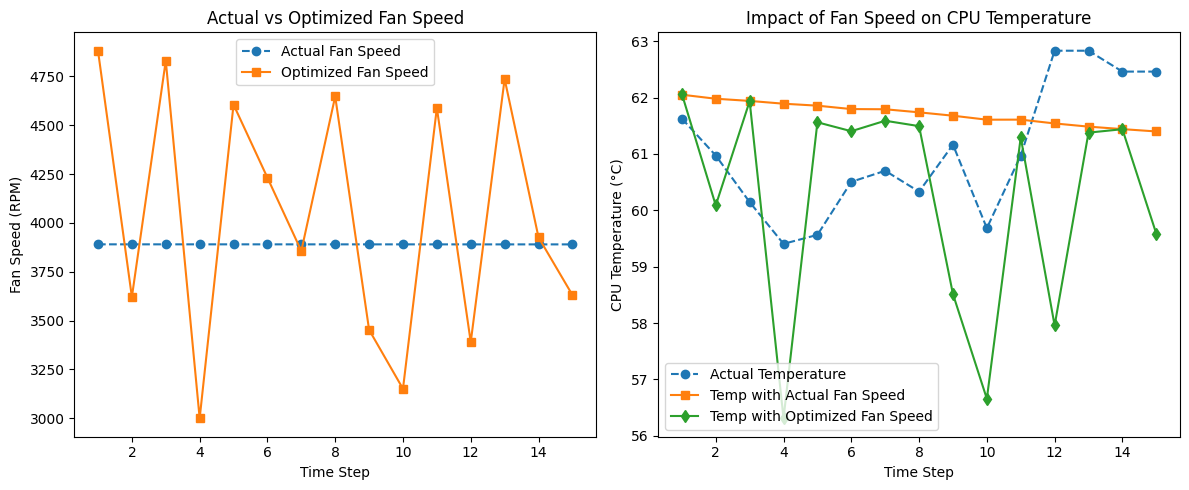

In [21]:
time_steps = np.arange(1, k_step + 1)

# Plot actual and best fan speed
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(time_steps, actual_fan_speed, label="Actual Fan Speed", marker="o", linestyle="--")
plt.plot(time_steps, best_fan_speed, label="Optimized Fan Speed", marker="s", linestyle="-")
plt.xlabel("Time Step")
plt.ylabel("Fan Speed (RPM)")
plt.title("Actual vs Optimized Fan Speed")
plt.legend()

# Compare effects on chip temperature
plt.subplot(1, 2, 2)
plt.plot(time_steps, actual_values, label="Actual Temperature", marker="o", linestyle="--")
plt.plot(time_steps, original_forecast, label="Temp with Actual Fan Speed", marker="s", linestyle="-")
plt.plot(time_steps, modified_forecast, label="Temp with Optimized Fan Speed", marker="d", linestyle="-")
# plt.ylim(30, 60)
plt.xlabel("Time Step")
plt.ylabel("CPU Temperature (°C)")
plt.title("Impact of Fan Speed on CPU Temperature")
plt.legend()

plt.tight_layout()
plt.show()
